I'll use the quick and easy ``pyfftw.interfaces`` module of the package ``FFTW`` to perform the Fourier transform of a 3D Gaussian random field. We use the default setting:

The Gaussian random field is 
$$
    \delta(\boldsymbol{x}) \sim \mathcal{N} (0,1),
$$
then 
$$
    \sum_{\boldsymbol{x}} \delta(\boldsymbol{x}) \mathrm{e}^{- \mathrm{i} \boldsymbol{k} \cdot \boldsymbol{x}} \sim \mathcal{N} \left(0, \sum_{\boldsymbol{x}} | \mathrm{e}^{- \mathrm{i} \boldsymbol{k} \cdot \boldsymbol{x}} |^2 \right) = \mathcal{N} (0, N^3).
$$
That is, the Fourier modes of a Gaussian random field follows Gaussian distribution:
$$
    \tilde{\delta} (\boldsymbol{k}) = H^3  \sum_{\boldsymbol{x}} \delta(\boldsymbol{x}) \mathrm{e}^{- \mathrm{i} \boldsymbol{k} \cdot \boldsymbol{x}} \sim \mathcal{N} (0, H^6 N^3).
$$

The rescaled Fourier mode is given by
$$
    \tilde{\delta}'(\boldsymbol{k}) = \sqrt{\frac{PL_{\mathrm{fit}}(k)}{H^3}} \tilde{\delta} (\boldsymbol{k}).
$$

Next, I need to measure the power spectrum of the field I just generated. I'll write a **power spectrum estimator** to do this.

Here we measure the binned spherically-averaged power spectrum, which is 
$$
    \hat{P} (k_i) = \frac{1}{N} \sum_{|k - k_i| < \frac{\Delta k}{2}} \frac{1}{V} |\tilde{\delta}(\boldsymbol{k})|^2,
$$
where $N$ is the number of points in the binned area.

In [1]:
from cosmology_amilly.gaussian_random_field import Gaussian_Random_Field

grf = Gaussian_Random_Field(
    L=1000, N=128, z=0, file_path="test_data_source/camb_0.dat"
)

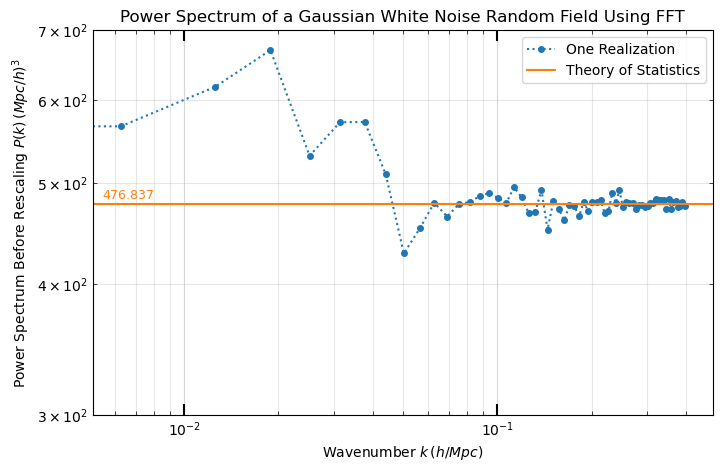

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
k_fig = grf.grid.discrete_k
P_fig = grf.binned_ps_grf(rescale=False)
plt.plot(k_fig, P_fig, "o:", label="One Realization", markersize=4)
plt.xlabel("Wavenumber $k \\, (h/Mpc)$")
plt.ylabel("Power Spectrum Before Rescaling $P(k) \\, (Mpc/h)^3$")
plt.title("Power Spectrum of a Gaussian White Noise Random Field Using FFT")

P_theory = grf.grid.H**3
plt.axhline(y=P_theory, color="C1", linestyle="-", label="Theory of Statistics")
plt.text(
    0.1,
    P_theory * 1.02,
    f"{P_theory:.3f}",
    ha="right",
    va="center",
    transform=plt.gca().get_yaxis_transform(),
    color="C1",
    fontsize=9,
)
plt.xscale("log")
plt.yscale("log")
plt.ylim(300, 700)
plt.tick_params(axis="both", direction="in", length=8, width=1.5, top=True, right=True)
plt.tick_params(
    which="minor", direction="in", length=3, width=0.5, top=True, right=True
)
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()

Then I apply the estimator to the $\tilde{\delta} (\boldsymbol{k})$ to get the binned power spectrum using FFT, and make a comparison between it and the data from CAMB.

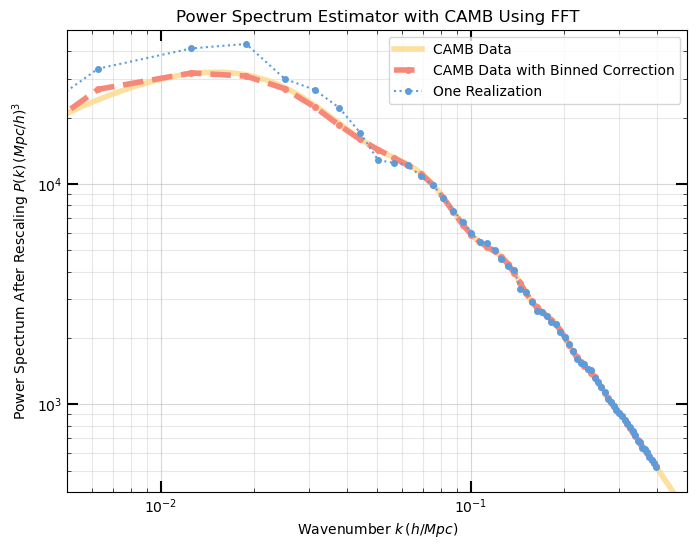

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
k_CAMB = []
P_CAMB = []
k_CAMB, P_CAMB = np.loadtxt("test_data_source/camb_0.dat", unpack=True)
plt.plot(
    k_CAMB, P_CAMB, label="CAMB Data", color="#FDD786C8", linestyle="-", linewidth=4
)

P_rescale = grf.binned_ps_grf(rescale=True)
P_correction = grf.binned_correction()
plt.plot(
    k_fig,
    P_correction,
    "--",
    label="CAMB Data with Binned Correction",
    color="#F78779",
    marker="o",
    linewidth=4,
    markersize=4,
)
plt.plot(k_fig, P_rescale, "o:", label="One Realization", color="#5D9CDB", markersize=4)

plt.xlabel("Wavenumber $k \\, (h/Mpc)$")
plt.ylabel("Power Spectrum After Rescaling $P(k) \\, (Mpc/h)^3$")
plt.title("Power Spectrum Estimator with CAMB Using FFT")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.005, 0.5)
plt.ylim(400, 50000)
plt.tick_params(axis="both", direction="in", length=8, width=1.5, top=True, right=True)
plt.tick_params(
    which="minor", direction="in", length=3, width=0.5, top=True, right=True
)
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()

Here I need to generate 20 realizations and compute the ensemble mean of the power spectrum and the standard deviation.

In [4]:
from tqdm import tqdm

def Ensemble_GRF(n_realizations):
    results = []
    for i in tqdm(range(n_realizations)):
        grf = Gaussian_Random_Field(L=1000, N=128, z=0, file_path="test_data_source/camb_0.dat")
        P = grf.binned_ps_grf(rescale=True)
        results.append(P)
    mean_P = np.mean(results, axis=0)
    std_P = np.std(results, axis=0)
    sem_P = std_P / np.sqrt(n_realizations)
    return mean_P, sem_P

In [5]:
P_mean, P_sem = Ensemble_GRF(20)

100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


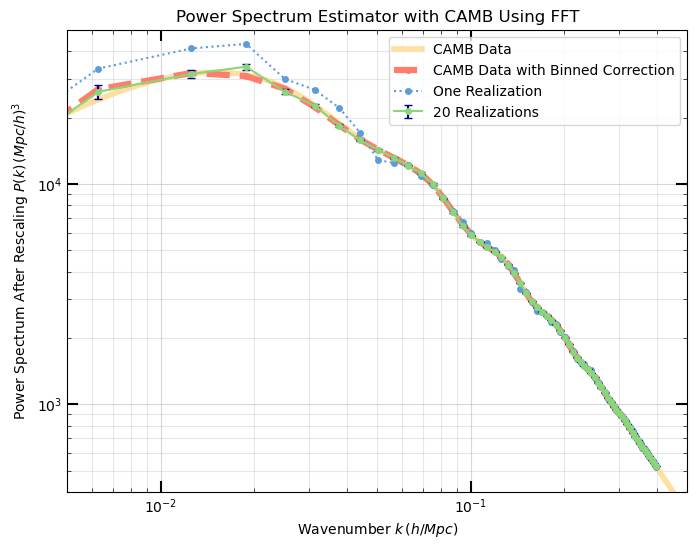

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(
    k_CAMB, P_CAMB, label="CAMB Data", color="#FDD786C8", linestyle="-", linewidth=4
)

plt.plot(
    k_fig,
    P_correction,
    "--",
    label="CAMB Data with Binned Correction",
    color="#FF7D6C",
    marker="o",
    linewidth=4.5,
    markersize=4,
)


plt.plot(k_fig, P_rescale, "o:", label="One Realization", color="#5D9CDB", markersize=4)

plt.errorbar(
    k_fig,
    P_mean,
    yerr=P_sem,
    fmt="o-",
    label="20 Realizations",
    markersize=4,
    color="#8BD678",
    ecolor="darkblue",
    capsize=3,
)

plt.xlabel("Wavenumber $k \\, (h/Mpc)$")
plt.ylabel("Power Spectrum After Rescaling $P(k) \\, (Mpc/h)^3$")
plt.title("Power Spectrum Estimator with CAMB Using FFT")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.005, 0.5)
plt.ylim(400, 50000)
plt.tick_params(axis="both", direction="in", length=8, width=1.5, top=True, right=True)
plt.tick_params(
    which="minor", direction="in", length=3, width=0.5, top=True, right=True
)
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()

In [7]:
P_mean_1000, P_sem_1000 = Ensemble_GRF(1000)

100%|██████████| 1000/1000 [02:02<00:00,  8.13it/s]


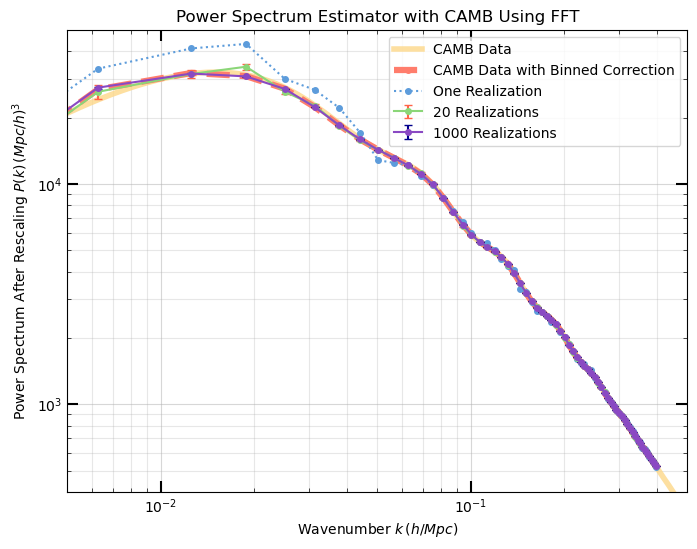

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(k_CAMB, P_CAMB, label="CAMB Data", color="#FDD786C8", linestyle="-", linewidth=4)

plt.plot(
    k_fig,
    P_correction,
    "--",
    label="CAMB Data with Binned Correction",
    color="#FF7D6C",
    marker="o",
    linewidth=4.5,
    markersize=4,
)


plt.plot(k_fig, P_rescale, "o:", label="One Realization", color="#5D9CDB", markersize=4)

plt.errorbar(
    k_fig,
    P_mean,
    yerr=P_sem,
    fmt="o-",
    label="20 Realizations",
    markersize=4,
    color="#8BD678",
    ecolor="tomato",
    capsize=3,
)

plt.errorbar(
    k_fig,
    P_mean_1000,
    yerr=P_sem_1000,
    fmt="o-",
    label="1000 Realizations",
    markersize=4,
    color="#8A49C3FF",
    ecolor="darkblue",
    capsize=3,
)

plt.xlabel("Wavenumber $k \\, (h/Mpc)$")
plt.ylabel("Power Spectrum After Rescaling $P(k) \\, (Mpc/h)^3$")
plt.title("Power Spectrum Estimator with CAMB Using FFT")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.005, 0.5)
plt.ylim(400, 50000)
plt.tick_params(axis="both", direction="in", length=8, width=1.5, top=True, right=True)
plt.tick_params(
    which="minor", direction="in", length=3, width=0.5, top=True, right=True
)
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()

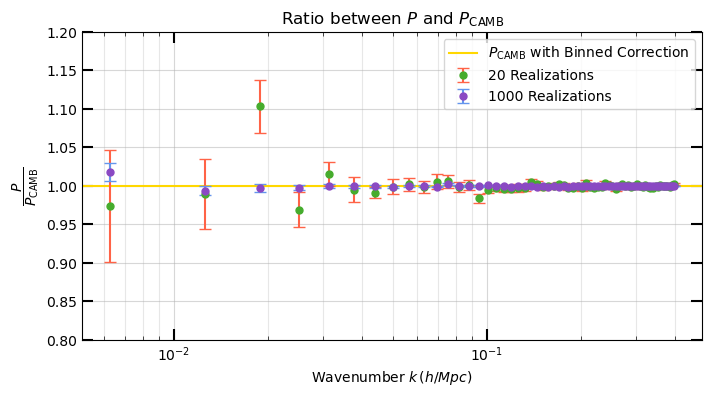

In [9]:
def ratio(P):
    _ratio = np.divide(P, P_correction, out=np.full_like(P, np.nan), where=P_correction!=0
    )
    return _ratio


def ratio_err(P_err):
    _ratio_err = np.divide(P_err, P_correction, out=np.full_like(P_err, np.nan), where=P_correction!=0
    )
    return _ratio_err

ratio_20 = ratio(P_mean)
ratio_1000 = ratio(P_mean_1000)

plt.figure(figsize=(8, 4))

plt.axhline(y=1, color="gold", linestyle="-", label="$P_{\\rm CAMB}$ with Binned Correction")
plt.errorbar(
    k_fig, ratio_20, yerr=ratio_err(P_sem), fmt="o", markersize=5, color="#46AC2D", ecolor='tomato', label='20 Realizations', capsize=4
)

plt.errorbar(
    k_fig,
    ratio_1000,
    yerr=ratio_err(P_sem_1000),
    fmt="o",
    markersize=5,
    color="#8A49C3FF",
    ecolor="cornflowerblue",
    label="1000 Realizations",
    capsize=4,
)

plt.xscale("log")
plt.ylim(0.8, 1.2)

plt.xlabel("Wavenumber $k \\, (h/Mpc)$")
plt.ylabel("$\\dfrac{P}{P_{\\rm CAMB}}$")
plt.title("Ratio between $P$ and $P_{\\rm CAMB}$")
plt.tick_params(axis="both", direction="in", length=8, width=1.5, top=True, right=True)
plt.tick_params(
    which="minor", direction="in", length=3, width=0.5, top=True, right=True
)
plt.grid(which="major", alpha=0.5)
plt.grid(which="minor", alpha=0.3)
plt.legend()
plt.show()